In [1]:
import torch.nn.functional as F
import voc12.dataloader
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM    
from misc import imutils
import matplotlib.pyplot as plt

In [2]:
val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
cam_weight_path = '/Users/Andy/Projects/dataset/Models/Classification/resnet50.pth'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
data_loader = DataLoader(val_dataset, shuffle=False)

model = CAM()
model.eval()
model.load_state_dict(torch.load(cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [3]:
data_iter = iter(data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']

    strided_size = imutils.get_strided_size(size, 4)
    strided_up_size = imutils.get_strided_up_size(size, 16)

    outputs = [model(img[0]) for img in pack['img']]

    strided_cam = torch.sum(torch.stack(
        [F.interpolate(torch.unsqueeze(o, 0), strided_size, mode='bilinear', align_corners=False)[0] for o
         in outputs]), 0)

#     highres_cam = [F.interpolate(torch.unsqueeze(o, 1), strided_up_size,
#                                  mode='bilinear', align_corners=False) for o in outputs]
#     highres_cam = torch.sum(torch.stack(highres_cam, 0), 0)[:, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]
    print(valid_cat)
    print(strided_cam.shape)

    strided_cam = strided_cam[valid_cat]
    strided_cam /= F.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5

#     highres_cam = highres_cam[valid_cat]
#     highres_cam /= F.adaptive_max_pool2d(highres_cam, (1, 1)) + 1e-5

/Users/Andy/Projects/front_door_cam/misc/imutils.py:174: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


tensor([ 1, 14])
torch.Size([20, 125, 84])


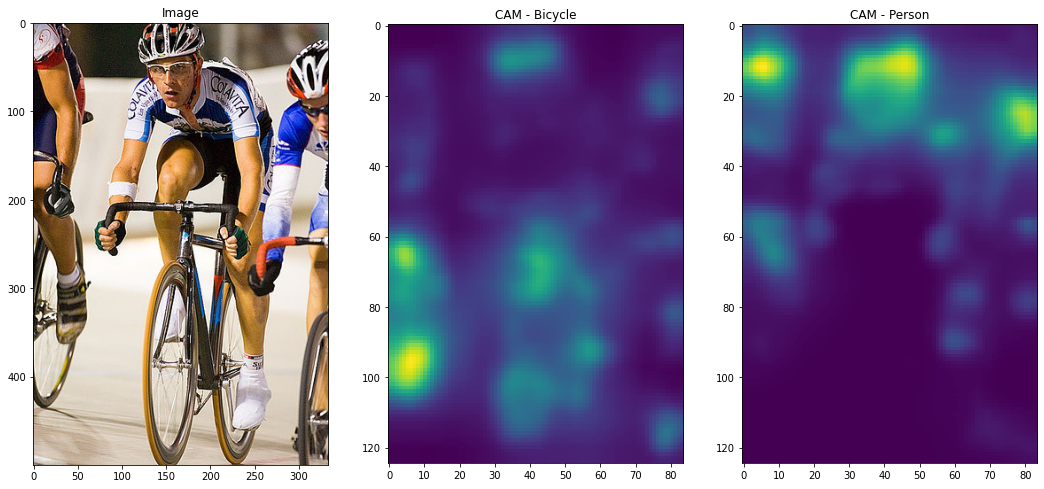

In [4]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(131)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(132)
plt.title('CAM - Bicycle')
ax2.imshow(strided_cam[0].squeeze())
ax3 = fig.add_subplot(133)
plt.title('CAM - Person')
ax3.imshow(strided_cam[1].squeeze())

# Front-Door Criterion

Consider the graph depicted the causal relationship between the image $X$ and its segmentation mask $Y$. The tag $Z$ is the image-level label assigned to each image. For instance, it would be "bicycle" and "person" for the image in the above. 

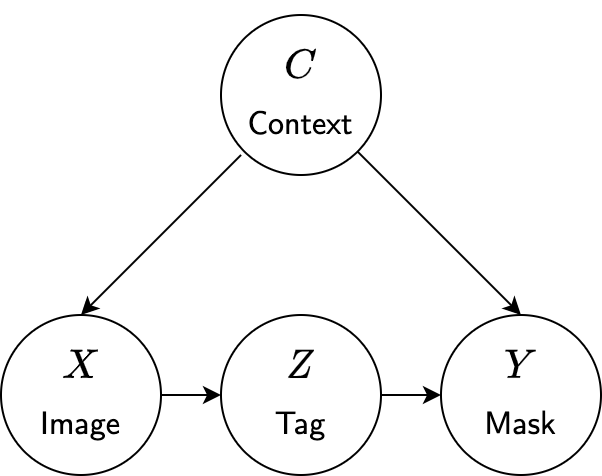

$C\rightarrow X$ and $C\rightarrow Y$. The context prior $C$ pictures the relationships among objects (e.g. person on the bicycle) and the characteristics (e.g., colour and shape) of objects in a scene. Hence, it determines what to picture in an image $X$. Moreover, it also causally influence the final segmentation mask $Y$. 

$X\rightarrow Z$. The tag $Z$ of an image is determined by the image $X$. Context prior $C$ cannot directly affect the labels $Z$ of an image. 

$Z\rightarrow Y$. The segmentation mask $Y$ is determined by the tag $Z$ as the tag(s) restricts the object to be segmented. For instance, if the background of an image contains semantic objects, if the tag doesn't include that class of the object, the segmentation mask $Y$ will assign "background" to those pixels.

Thanks to the graph, we can clearly see $C$ confounds $X$ and $Y$ via the backdoor path from $X$ to $Y$. However, $C$ is unobservable and hence cannot be used to block the backdoor path from $X$ to $Y$. Nevertheless, by applying two conceutive applications of the backdoor criterion, we can identify the causal effect $P(Y = y|do(X=x))$. This is also known as the **Front-Door Adjustment**. 

As the image tag $Z$ satisifies the front-door criterion relative to $(X,Y)$, then the causal effect of $X$ on $Y$ is identifiable is given by formula

$$
P(y|do(x)) = \sum_zP(z|x)\sum_{x'}P(y|x',z)P(x')
$$

The derivation is as follows. We first note the causal effect of $X$ on $Z$ is identifiable, as there is no backdoor path from $X$ to $Z$. Thus, by *Back-Door Adjustment*, we have

$$
P(Z=z|do(X=x)) = P(Z=z|X=x)
$$

Second we note the effect of $Z$ of $Y$ is also identifiable, since the backdoor path from $Z$ to $Y$, $Z\leftarrow X \leftarrow C \rightarrow Y$, can be blcoked by conditioing on $X$. Thus, by $Back-Door Adjustment$, we have

$$
P(Y=y|do(Z=z)) = \sum_x P(Y=y|Z=z,X=x)
$$

Combining the above two equations gives us the results produced by *Front-Door Adjustmentz*. 

# Intervene on Weakly-Supervised Semantic Segmentation

Suppose we have a classification network which will produce a probability distrition $P(z|x)$ over the given classes in a dataset. Moreover, with class activation map, we also can estimate $P(y|x, z)$ which contains the attention map over the given classes in a dataset. Finally, under the assumption $P(x')$ is uniform, i.e., $\frac{1}{N}$ where $N$ is the number of images in a given dataset. This assumption is reasonable as the training samples are equiprobable. 

However, the tricky part of utilizing front-door adjustment is the summations over all $x$ in the dataset. 